In [1]:
import  numpy as np
import matplotlib as plt

In [2]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller


In [3]:
#jut a dirty trick
from scipy.optimize import minimize


from lib.math_sh import decompose
from lib.expected import expected
from lib.matchgate_01 import swap_t
from lib.inefficient_VQE import *

In [4]:
backend=Aer.get_backend('qasm_simulator')

In [5]:
#Exact solver for reference:
def Exact_solver(qubitOp):
    ex = NumPyEigensolver(qubitOp)
    result = ex.run()
    ref = result['eigenvalues']
    return np.real(ref)

In [6]:
basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'H .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))
#print('# one elctron integral:\n',h1)
#print('# two elctron integral:\n',h2)

HF energy: -1.3194643767935124
# nr. of electrons: 2
# nr. of spin orbitals: 4


In [7]:
ferOp = FermionicOperator(h1=h1, h2=h2)
qubitOp = ferOp.mapping(map_type='jordan_wigner')

print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())

Representation: paulis, qubits: 4, size: 15
IIII	(-0.8517840380466506+0j)
IIIZ	(0.10053557435398455+0j)
IIZI	(-0.049032364414860446+0j)
IZII	(0.10053557435398452+0j)
ZIII	(-0.04903236441486046+0j)
IIZZ	(0.08678749878785741+0j)
IZIZ	(0.14120468151365045+0j)
XXYY	(0.05575552226867875+0j)
YYYY	(0.05575552226867875+0j)
XXXX	(0.05575552226867875+0j)
YYXX	(0.05575552226867875+0j)
ZIIZ	(0.14254302105653616+0j)
IZZI	(0.14254302105653616+0j)
ZIZI	(0.14891189696596438+0j)
ZZII	(0.08678749878785741+0j)



In [8]:
a= swap_t(5)
a.get_p()

thet= 5
math= [[ 1.          0.          0.          0.        ]
 [ 0.         -0.95892427  0.28366219  0.        ]
 [ 0.          0.28366219  0.95892427  0.        ]
 [ 0.          0.          0.         -1.        ]]


In [9]:
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
print(theta)

[0. 0. 0. 0.]


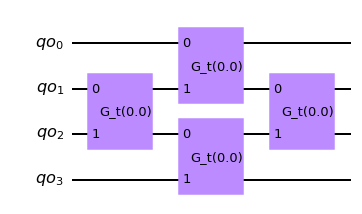

In [10]:
qo=QuantumRegister(nr_o,'qo')
ansatz = QuantumCircuit(qo)
ansatz_cell(ansatz,qo,nr_o, nr_e,theta)
ansatz.draw('mpl')

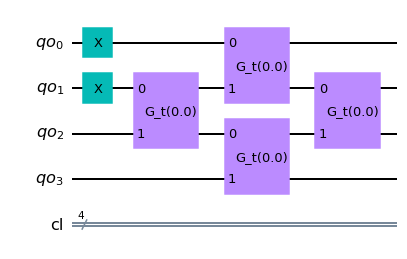

In [11]:
circ=var_circ(nr_o,nr_e,theta)
circ.draw('mpl')

In [12]:

def VQE(weight,pauli,nr_o,nr_e,backend):
    
    theta=np.zeros(nr_par)
    optim=minimize(cost, 
                   theta,args=(weight,pauli,nr_o,nr_e,backend),
                   method='COBYLA', 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 'disp': True, 'catol': 0.0002})
    
    circ=var_circ(nr_o,nr_e,optim.x)
    eigval=value(weight,pauli,circ,backend)
    
    return eigval


In [ ]:
VQEresult=np.real(VQE(weight,pauli,nr_o,nr_e,backend))

/Users/voicutu/opt/anaconda3/envs/venvCQ/lib/python3.8/site-packages/scipy/optimize/cobyla.py:250: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = _cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


In [15]:
print("Result: ",VQEresult)
print("Reference:",Exact_solver(qubitOp))

Result:  -1.3442816619206666
Reference: -1.393451971373958
